Irgiyansyah <br>
211351068

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irgiys","key":"8e9e867d3f54018acd12e3e707b02820"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d iammustafatz/diabetes-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
License(s): copyright-authors
100% 734k/734k [00:00<00:00, 1.60MB/s]
100% 734k/734k [00:00<00:00, 1.60MB/s]


In [5]:
!mkdir diabetes-prediction-dataset
!unzip diabetes-prediction-dataset.zip -d diabetes-prediction-dataset
!ls diabetes-prediction-dataset

Archive:  diabetes-prediction-dataset.zip
  inflating: diabetes-prediction-dataset/diabetes_prediction_dataset.csv  
diabetes_prediction_dataset.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

from keras.models import Sequential

from keras.layers import Dense
from tensorflow.keras.utils import plot_model
import seaborn as sns

In [7]:
# Inisialisasi DataFrame
df = pd.read_csv('/content/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')

In [8]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [10]:
# Hapus data duplikat
print("Sebelum dihapus: ", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Sesudah dihapus: ", df.duplicated().sum())

Sebelum dihapus:  3854
Sesudah dihapus:  0


In [11]:
# Cek null data
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [12]:
# Ubah tipedata age
print("Sebelum : " ,df.shape)
df = df[df['age'].mod(1) == 0]
df.loc[:, 'age'] = df['age'].astype(int)
print("Sesudah : " ,df.shape)

Sebelum :  (96146, 9)
Sesudah :  (94133, 9)


In [13]:
# Hapus data yang gendernya other
print("Sebelum : " ,df.shape)
index = df[df['gender'] == 'Other'].index
df = df.drop(index)
print("Sesudah : " ,df.shape)

Sebelum :  (94133, 9)
Sesudah :  (94115, 9)


In [14]:
# Kolom tipe object
object_columns = df.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['gender', 'smoking_history']


In [15]:
for columns in object_columns:
  print(df[columns].unique())

['Female' 'Male']
['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [16]:
# Ubah kategorikal smoking_status menjadi lebih sedikit
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

print(df['smoking_history'].value_counts())

smoking_history
non-smoker     65285
past_smoker    19638
current         9192
Name: count, dtype: int64


In [17]:
# Hapus data yang umurnya kurang dari sama dengan 18 karena usia dibawah 18 tidak rentan terhadap diabetes
print("before ", df.shape)
df = df[df['age'] >= 18]
print("after ", df.shape)

before  (94115, 9)
after  (79444, 9)


In [18]:
# Ubah data kategorikal menjadi numerik
le = LabelEncoder()
for columns in object_columns:
  print(df[columns].unique())
  df[columns] = le.fit_transform(df[columns])
  print(df[columns].unique())

['Female' 'Male']
[0 1]
['non-smoker' 'current' 'past_smoker']
[1 0 2]


<ipython-input-18-28365dbbb82d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = le.fit_transform(df[columns])
<ipython-input-18-28365dbbb82d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = le.fit_transform(df[columns])


<Axes: >

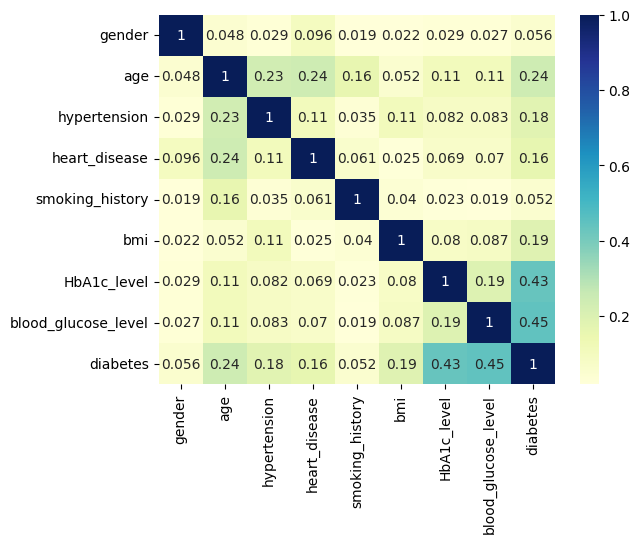

In [19]:
# Korelasi antarr kolom
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [20]:
# Featuring
X = df.drop(columns = ['diabetes'])

In [21]:
# Labeling
y = df['diabetes']

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
input_dim = X.shape[-1]
hidden_neurons1 = (input_dim + 1) // 2
hidden_neurons2 = int(2/3 * input_dim + 1)
hidden_neurons3 = min(hidden_neurons1, hidden_neurons2, 2 * input_dim - 1)

model = Sequential([
    Dense(hidden_neurons3, activation='relu', input_dim=input_dim),
    Dense(hidden_neurons3, activation='relu'),
    Dense(hidden_neurons3, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


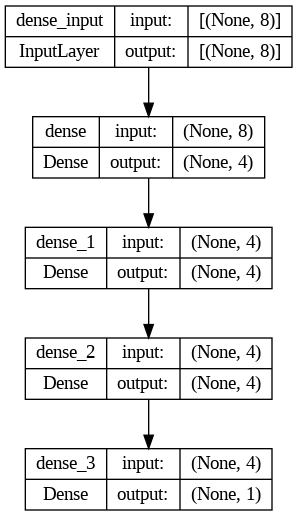

In [25]:
plot_model(model, show_shapes=True)

In [26]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
1738/1738 [==============================] - 6s 3ms/step - loss: 0.3418 - accuracy: 0.8929 - val_loss: 0.3185 - val_accuracy: 0.8974
Epoch 2/50
1738/1738 [==============================] - 7s 4ms/step - loss: 0.3204 - accuracy: 0.8929 - val_loss: 0.3073 - val_accuracy: 0.8974
Epoch 3/50
1738/1738 [==============================] - 5s 3ms/step - loss: 0.3107 - accuracy: 0.8929 - val_loss: 0.2981 - val_accuracy: 0.8974
Epoch 4/50
1738/1738 [==============================] - 6s 4ms/step - loss: 0.3031 - accuracy: 0.8929 - val_loss: 0.2917 - val_accuracy: 0.8974
Epoch 5/50
1738/1738 [==============================] - 5s 3ms/step - loss: 0.2967 - accuracy: 0.8929 - val_loss: 0.2861 - val_accuracy: 0.8974
Epoch 6/50
1738/1738 [==============================] - 5s 3ms/step - loss: 0.2915 - accuracy: 0.8929 - val_loss: 0.2808 - val_accuracy: 0.8974
Epoch 7/50
1738/1738 [==============================] - 6s 4ms/step - loss: 0.2872 - accuracy: 0.8929 - val_loss: 0.2786 - val_accuracy:

In [27]:
model.evaluate(X_test, y_test)

745/745 [==============================] - 1s 2ms/step - loss: 0.1449 - accuracy: 0.9517


[0.144949808716774, 0.9516656994819641]

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

745/745 [==============================] - 1s 1ms/step


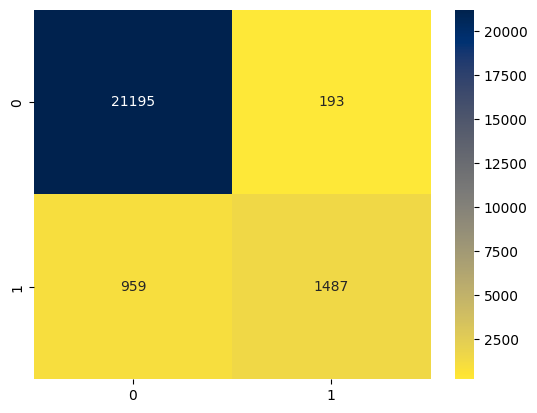

In [29]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='.0f', cmap='cividis_r')
plt.show()

In [30]:
# Imbalanced classes, disini saya menggunakan undersampler untuk mengurangi data dari kelas majority,
# Agar diprediksi tidak condong ke kelas majority
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

In [31]:
X_under, y_under = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3)

In [32]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
368/368 [==============================] - 1s 4ms/step - loss: 0.3228 - accuracy: 0.8607 - val_loss: 0.3034 - val_accuracy: 0.8706
Epoch 2/50
368/368 [==============================] - 2s 5ms/step - loss: 0.3106 - accuracy: 0.8665 - val_loss: 0.3096 - val_accuracy: 0.8653
Epoch 3/50
368/368 [==============================] - 2s 5ms/step - loss: 0.3068 - accuracy: 0.8661 - val_loss: 0.3077 - val_accuracy: 0.8673
Epoch 4/50
368/368 [==============================] - 1s 3ms/step - loss: 0.3061 - accuracy: 0.8661 - val_loss: 0.2939 - val_accuracy: 0.8683
Epoch 5/50
368/368 [==============================] - 1s 3ms/step - loss: 0.3000 - accuracy: 0.8664 - val_loss: 0.2866 - val_accuracy: 0.8728
Epoch 6/50
368/368 [==============================] - 1s 3ms/step - loss: 0.2987 - accuracy: 0.8648 - val_loss: 0.3851 - val_accuracy: 0.8220
Epoch 7/50
368/368 [==============================] - 1s 3ms/step - loss: 0.3025 - accuracy: 0.8616 - val_loss: 0.2909 - val_accuracy: 0.8687
Epoch 

In [33]:
model.evaluate(X_test, y_test)

158/158 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 0.8746


[0.2729659974575043, 0.8746031522750854]

158/158 [==============================] - 0s 1ms/step


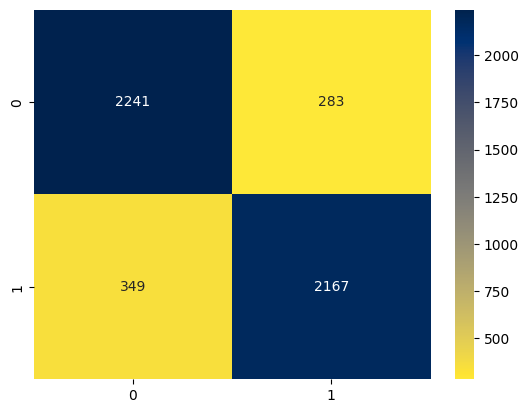

In [34]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='.0f', cmap='cividis_r')
plt.show()

In [35]:
# Sebelum melakukan undesample
y_pred = model.predict(X)
y_test = pd.DataFrame(y)
print(classification_report(y_test, y_pred.round()))

2483/2483 [==============================] - 4s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     71044
           1       0.47      0.86      0.61      8400

    accuracy                           0.88     79444
   macro avg       0.73      0.87      0.77     79444
weighted avg       0.93      0.88      0.90     79444



In [36]:
# Setelah melakukan undersample precision,recall dan f1 score pada class minoritas (1) cukup meningkat
y_pred = model.predict(X_under)
y_test = pd.DataFrame(y_under)
print(classification_report(y_test, y_pred.round()))

525/525 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      8400
           1       0.88      0.86      0.87      8400

    accuracy                           0.87     16800
   macro avg       0.87      0.87      0.87     16800
weighted avg       0.87      0.87      0.87     16800



In [37]:
df[df["diabetes"]==1].head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
6,0,44.0,0,0,1,19.31,6.5,200,1
26,1,67.0,0,1,2,27.32,6.5,200,1
38,1,50.0,1,0,0,27.32,5.7,260,1
40,1,73.0,0,0,2,25.91,9.0,160,1
53,0,53.0,0,0,2,27.32,7.0,159,1


In [38]:
# gender 	age 	hypertension 	heart_disease 	smoking_history 	bmi 	HbA1c_level 	blood_glucose_level
prediction = model.predict([[0,54.0,1,1,1,20.32,6.6,80]])
print(prediction)
prediction = model.predict([[0,44.0,0,0,1,19.31,6.5,200]])
print(prediction)

if prediction > 0.5 :
  print("Diabetes")
else :
  print("Not Diabetes")

1/1 [==============================] - 0s 96ms/step
[[0.26305547]]
1/1 [==============================] - 0s 37ms/step
[[0.5273745]]
Diabetes


In [39]:
keras_file = "diabetes_model.h5"
tf.keras.models.save_model(model, keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("diabetes_model.tflite", "wb").write(tflite_model)

<ipython-input-39-fab036faa638>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, keras_file)


2788